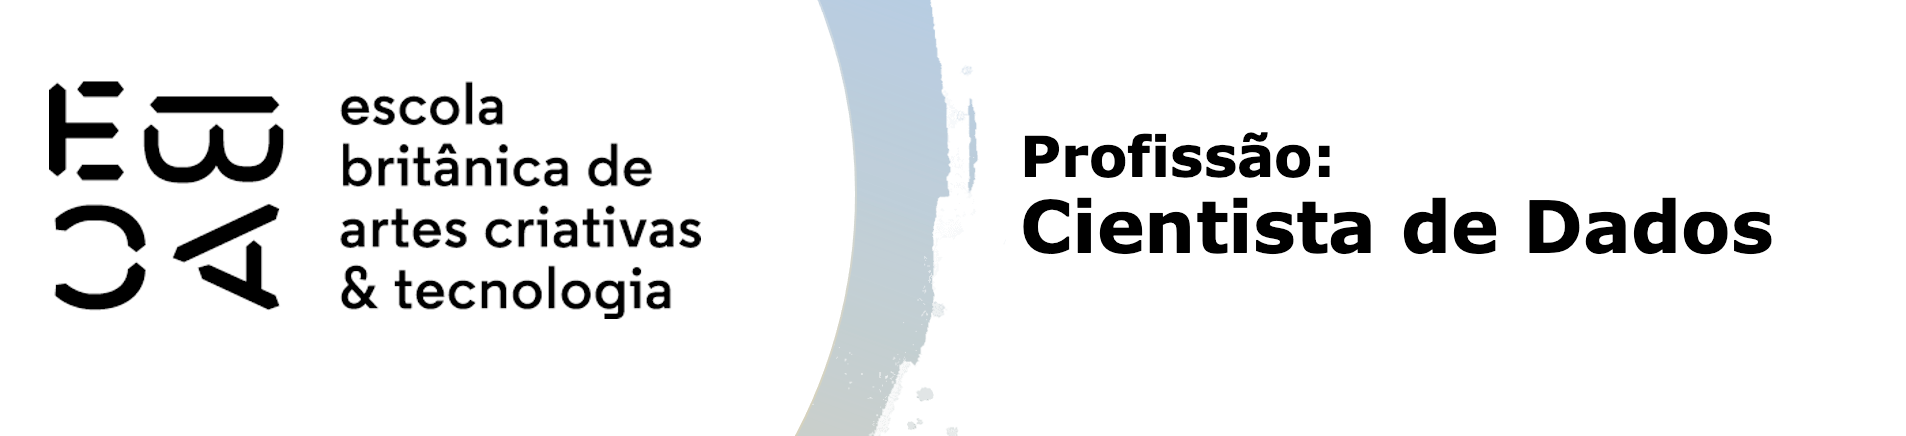

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix

In [23]:
df_raw = pd.read_feather('data/credit_scoring.ftr')
df_raw.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [15]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [12]:
#tratando variáveis
df = df_raw.drop(columns=['index'])

In [13]:
df_oot = df[df['data_ref'] >= (df['data_ref'].max() - pd.DateOffset(months=3))].copy()
df_train = df[df['data_ref'] < (df['data_ref'].max() - pd.DateOffset(months=3))].copy()

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [14]:
print(f"O dataset de treino tem {df_train.shape[0]} linhas")

O dataset de treino tem 550000 linhas


In [20]:
df_train[['data_ref', 'mau']].groupby('data_ref')\
                             .count()\
                             .reset_index()\
                             .rename(columns={'mau': 'quantidade', 'data_ref': 'Data Referencia'})

,Data Referencia,quantidade
0,2015-01-01,50000
1,2015-02-01,50000
2,2015-03-01,50000
3,2015-04-01,50000
4,2015-05-01,50000
5,2015-06-01,50000
6,2015-07-01,50000
7,2015-08-01,50000
8,2015-09-01,50000
9,2015-10-01,50000


In [29]:
#Variáveis qualitativas (categóricas)
qualitative_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'qt_pessoas_residencia', 'qtd_filhos']

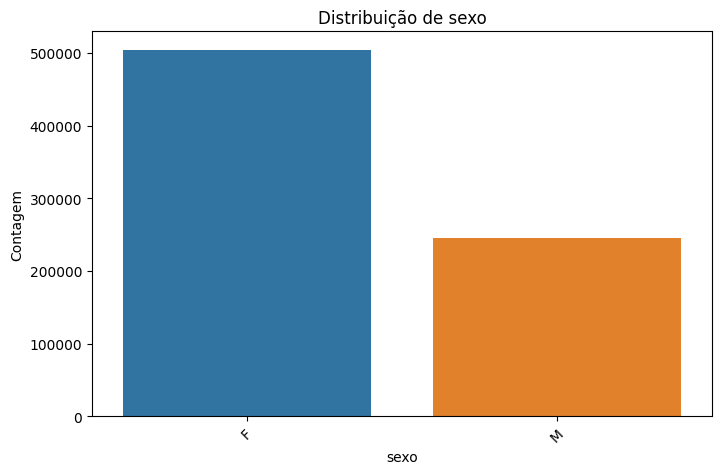

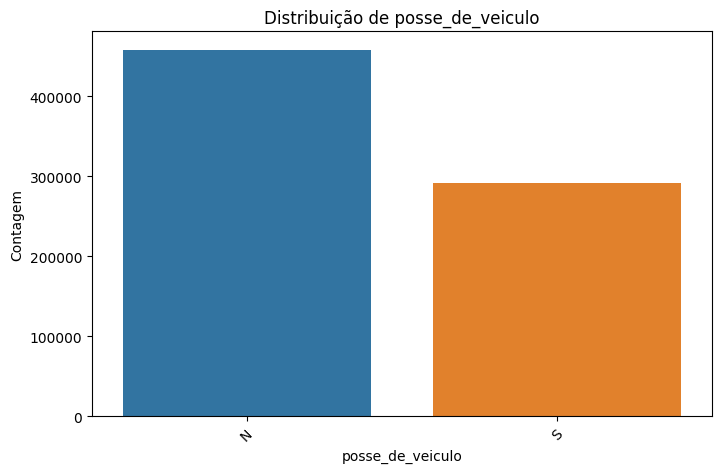

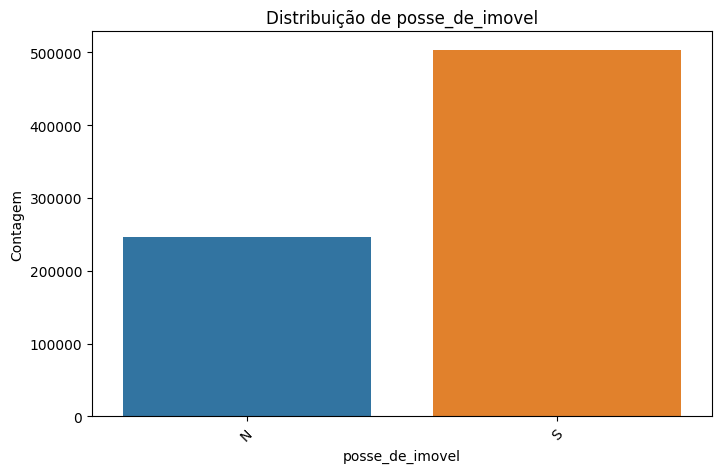

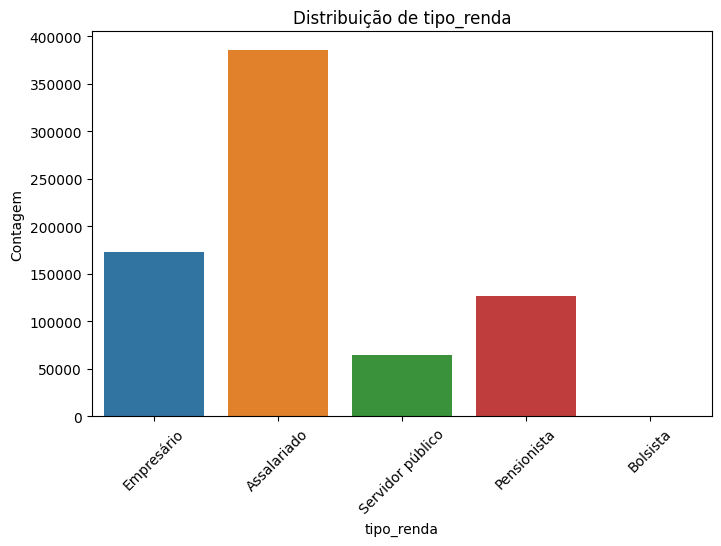

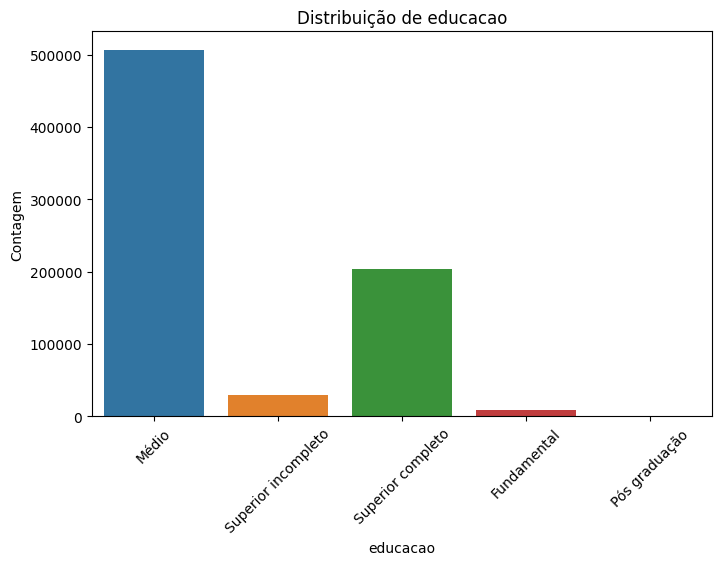

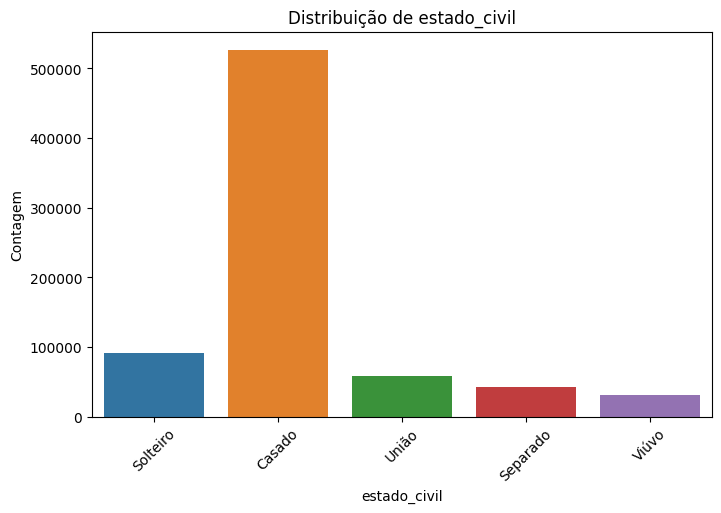

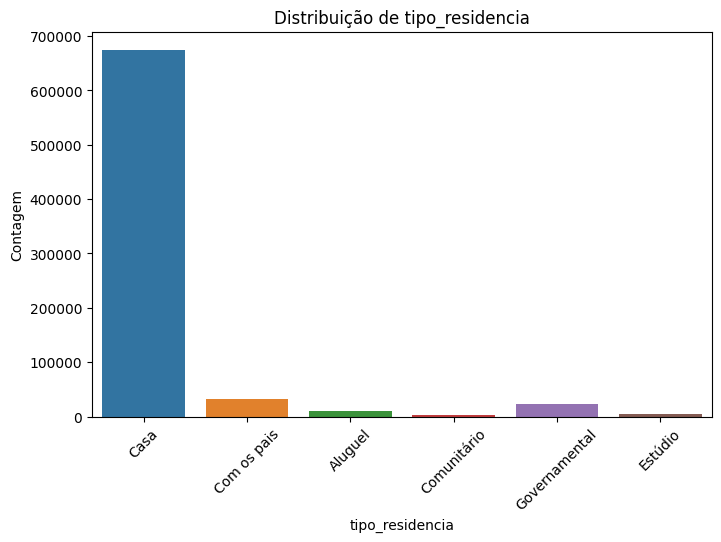

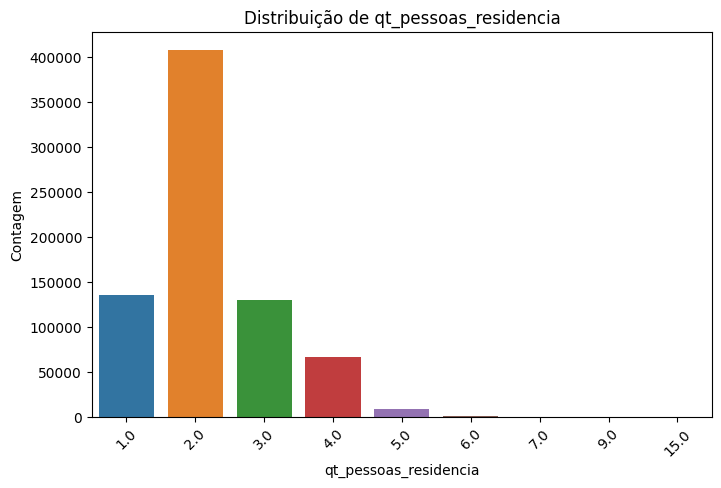

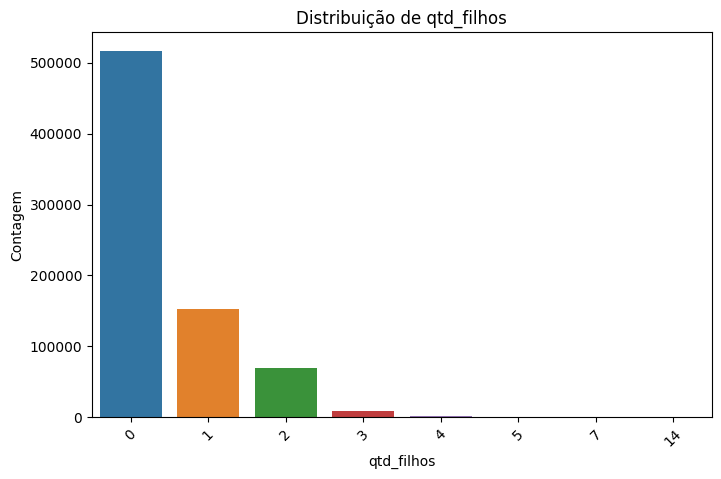

In [33]:
for var in qualitative_vars:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=var)
    plt.title(f"Distribuição de {var}")
    plt.xlabel(var)
    plt.ylabel("Contagem")
    plt.xticks(rotation=45)
    plt.show()

In [35]:
# Parte 2: Variáveis quantitativas (numéricas)
quantitative_vars = ['idade', 'tempo_emprego','renda']
df[quantitative_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
idade,750000.0,43.804733,11.229868,22.000000,34.000000,43.000000,53.000000,6.800000e+01
tempo_emprego,624043.0,7.748574,6.687455,0.117808,3.049315,6.046575,10.183562,4.290685e+01
renda,750000.0,23238.544747,79106.013795,107.670000,3467.700000,7861.820000,18318.280000,4.083986e+06


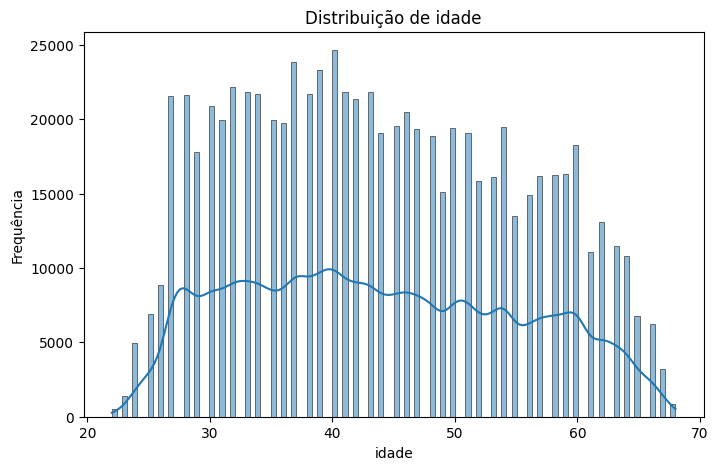

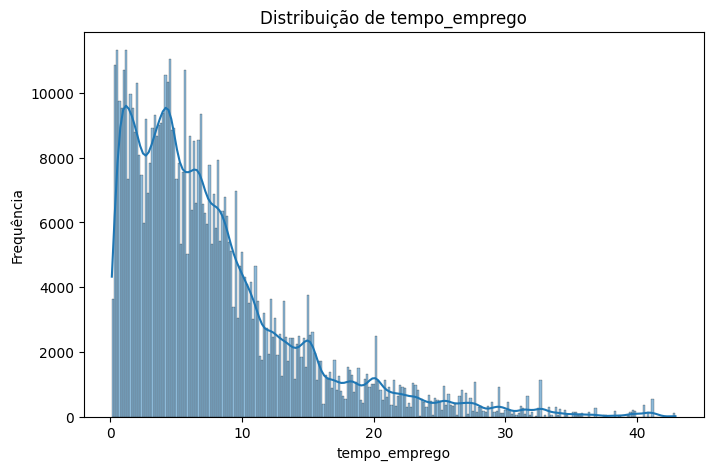

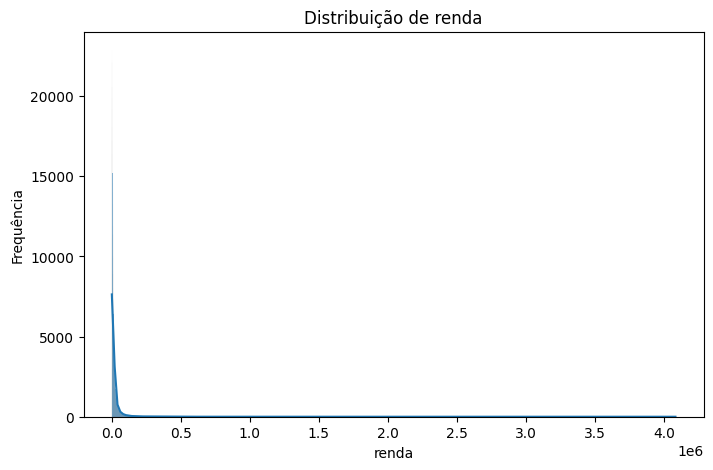

In [36]:
# Gráficos de distribuição para variáveis quantitativas
for var in quantitative_vars:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=var, kde=True)
    plt.title(f"Distribuição de {var}")
    plt.xlabel(var)
    plt.ylabel("Frequência")
    plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

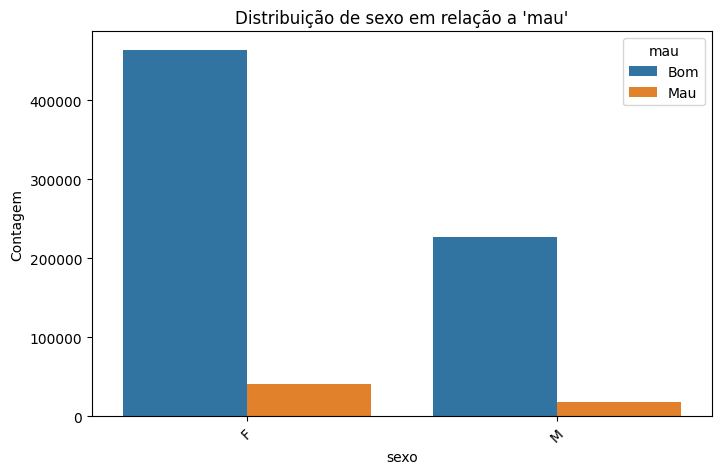

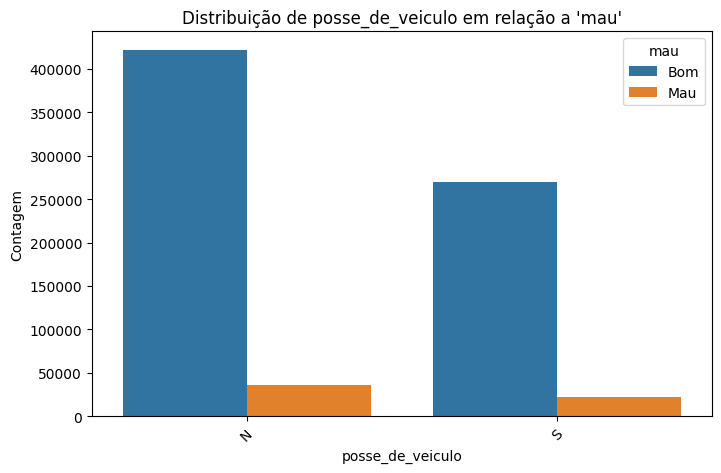

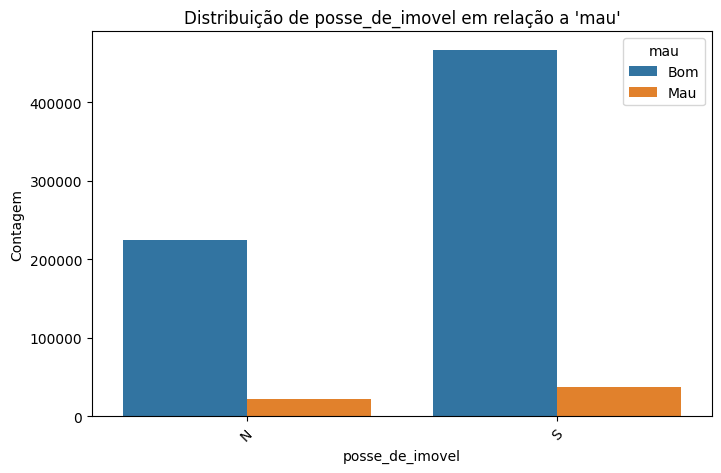

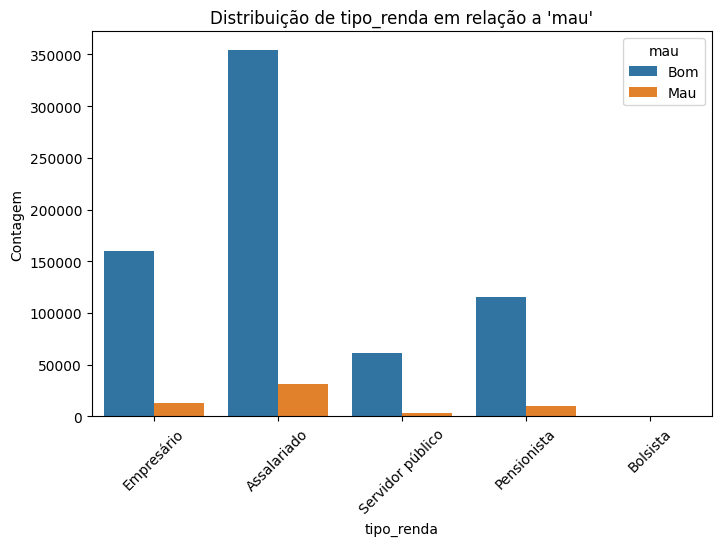

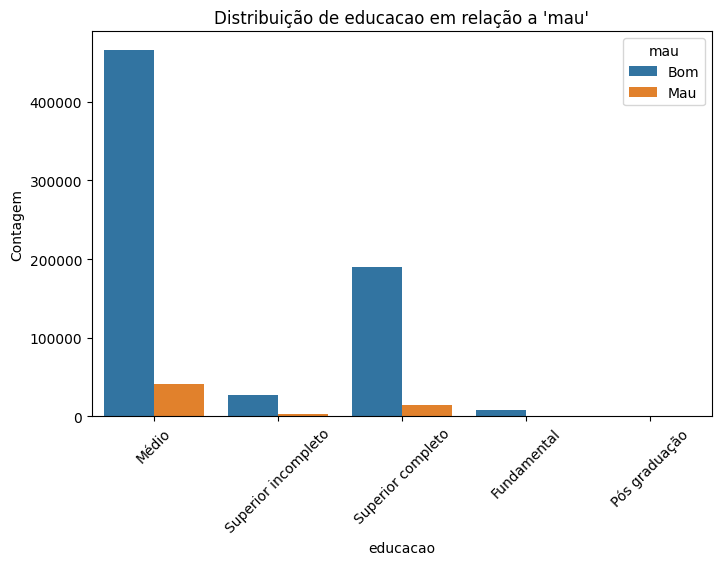

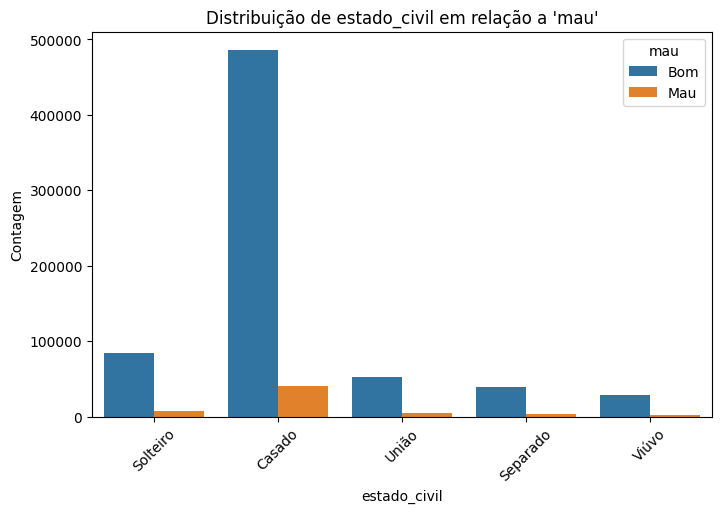

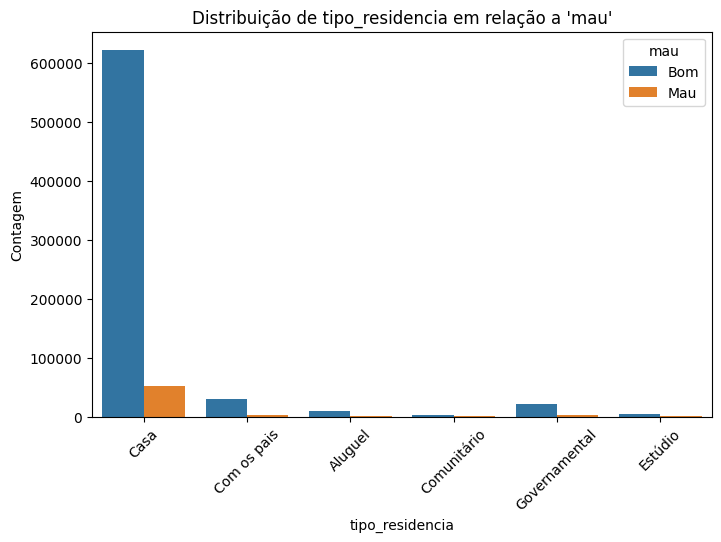

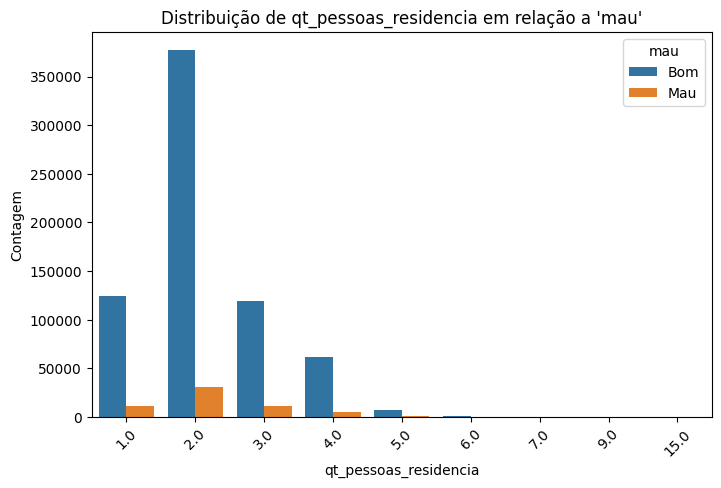

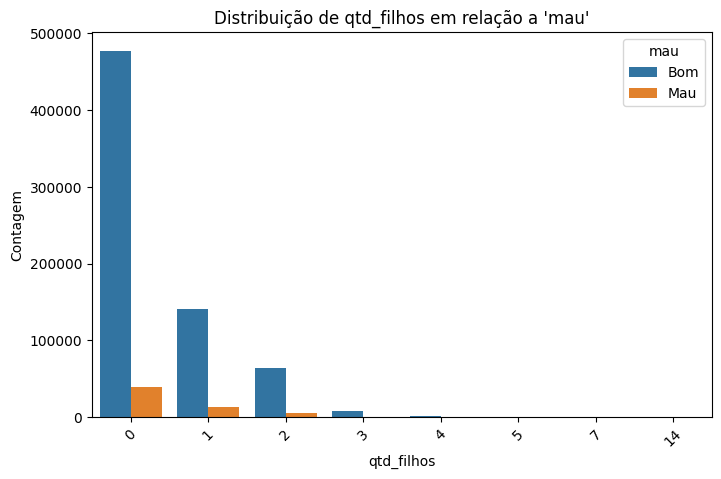

In [37]:
for var in qualitative_vars:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=var, hue='mau')
    plt.title(f"Distribuição de {var} em relação a 'mau'")
    plt.xlabel(var)
    plt.ylabel("Contagem")
    plt.xticks(rotation=45)
    plt.legend(title='mau', loc='upper right', labels=['Bom', 'Mau'])
    plt.show()

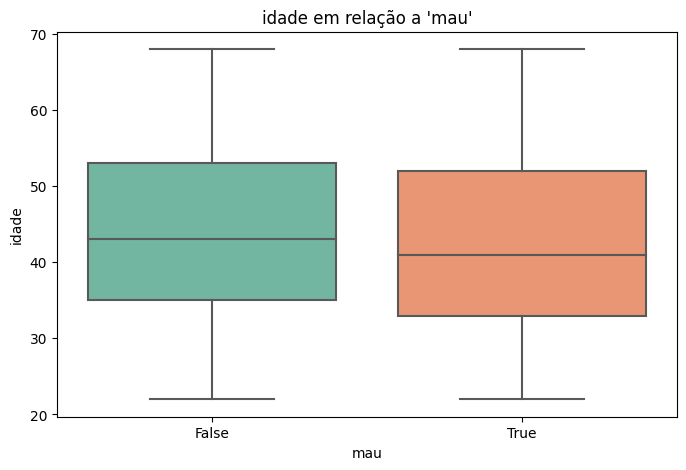

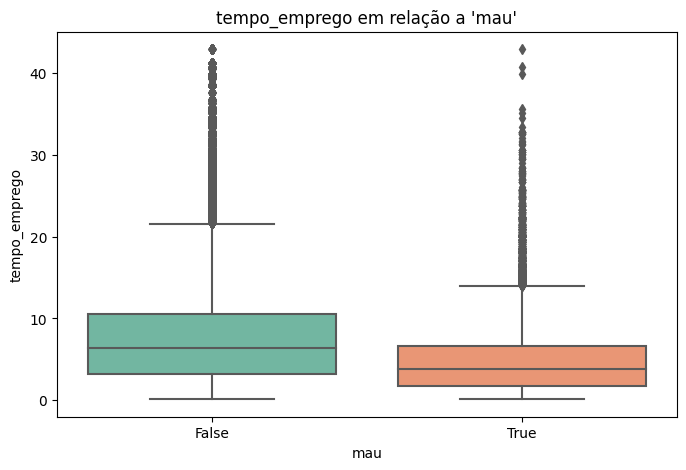

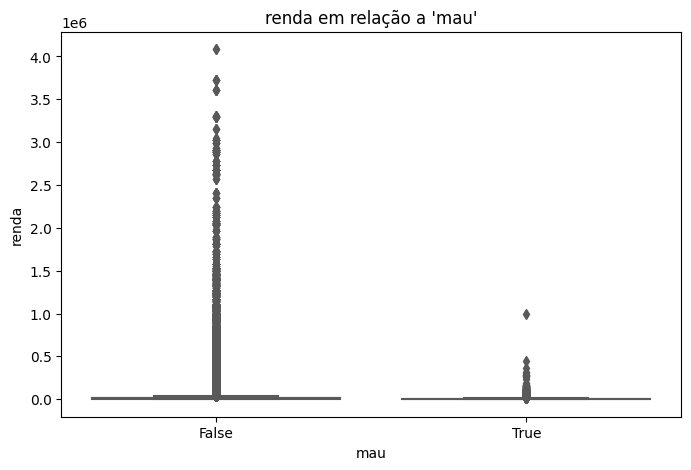

In [38]:
for var in quantitative_vars:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='mau', y=var, palette='Set2')
    plt.title(f"{var} em relação a 'mau'")
    plt.xlabel('mau')
    plt.ylabel(var)
    plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'

In [43]:
df_train['tempo_emprego'] = df_train['tempo_emprego'].fillna(0)

In [60]:
df_train.drop_duplicates(inplace=True)

In [64]:
df_train = df_train[df_train['renda'] < 4083986].copy()

In [113]:
df_train2 = df_train.copy()

- Faça agrupamentos de categorias conforme vimos em aula

In [114]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

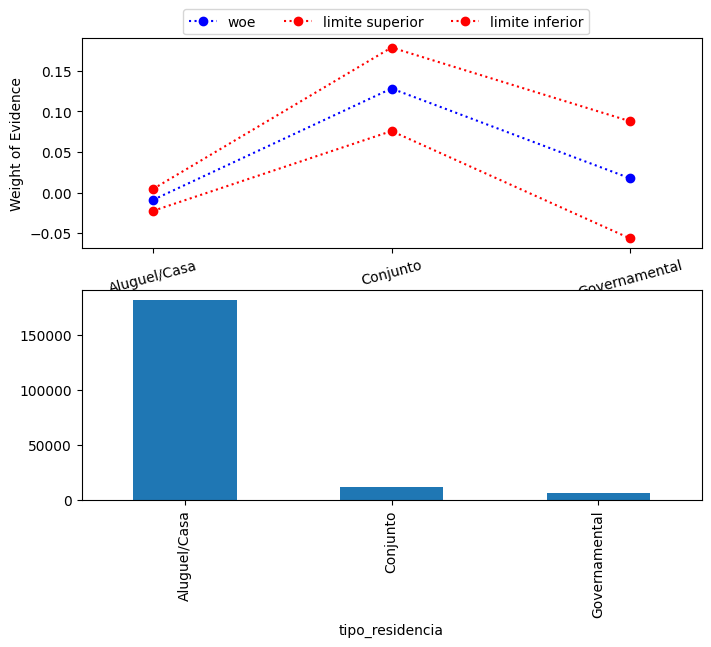

In [115]:
df_train2.tipo_residencia.replace({
    'Aluguel': 'Aluguel/Casa',
    'Estúdio': 'Aluguel/Casa',
    'Casa': 'Aluguel/Casa',
    'Comunitário': 'Conjunto',
    'Estúdio': 'Conjunto',
    'Com os pais': 'Conjunto',
}, inplace=True)
biv_discreta('tipo_residencia', df_train2);

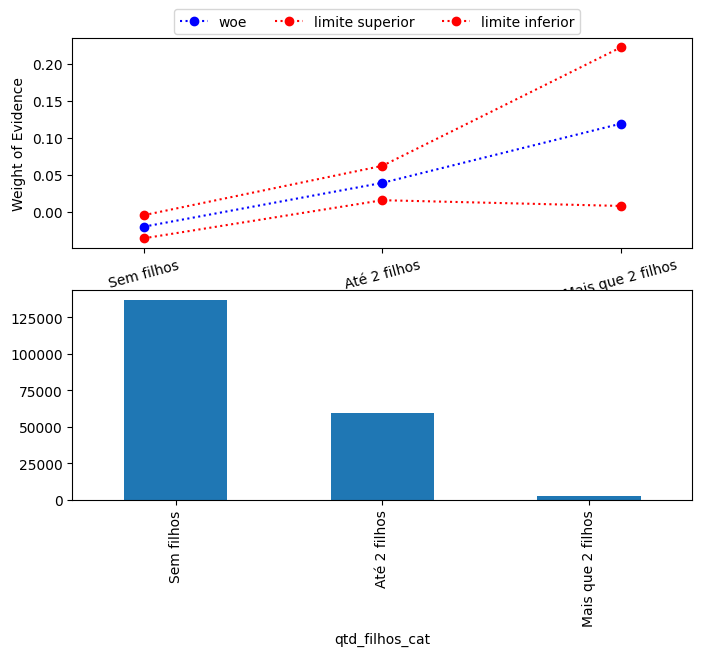

In [116]:
df_train2['qtd_filhos_cat'] = pd.cut(df['qtd_filhos'], bins=[-1, 0, 2, 15], labels=['Sem filhos', 'Até 2 filhos', 'Mais que 2 filhos'])
biv_discreta('qtd_filhos_cat', df_train2);

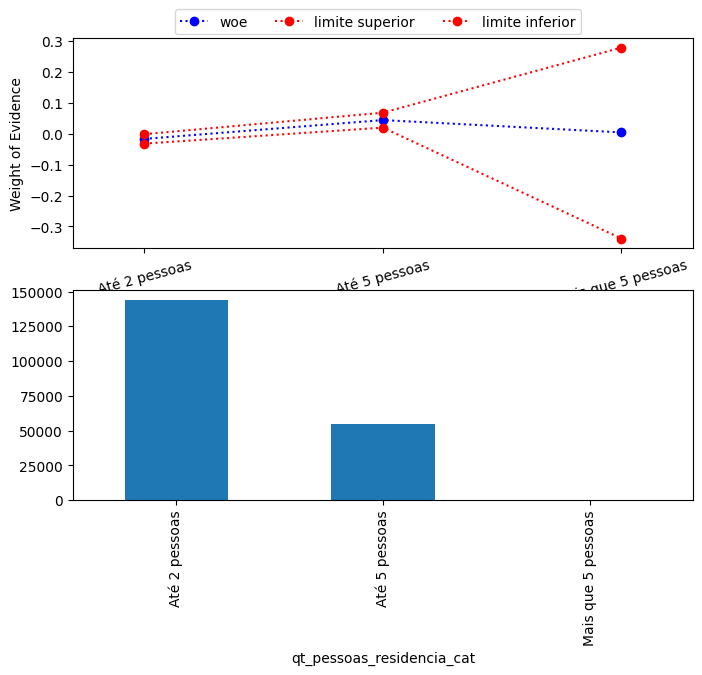

In [117]:
df_train2['qt_pessoas_residencia_cat'] = pd.cut(df['qt_pessoas_residencia'], bins=[-1, 2, 5, 15], labels=['Até 2 pessoas', 'Até 5 pessoas', 'Mais que 5 pessoas'])
biv_discreta('qt_pessoas_residencia_cat', df_train2);

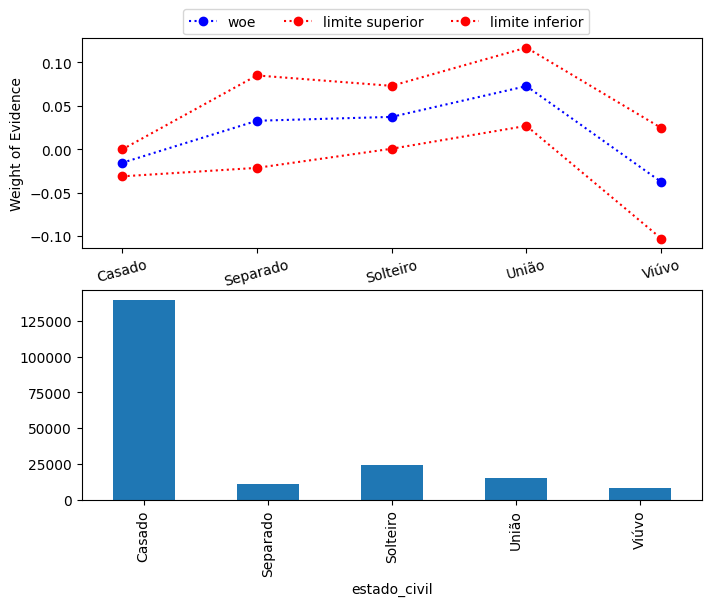

In [118]:
biv_discreta('estado_civil', df_train2);

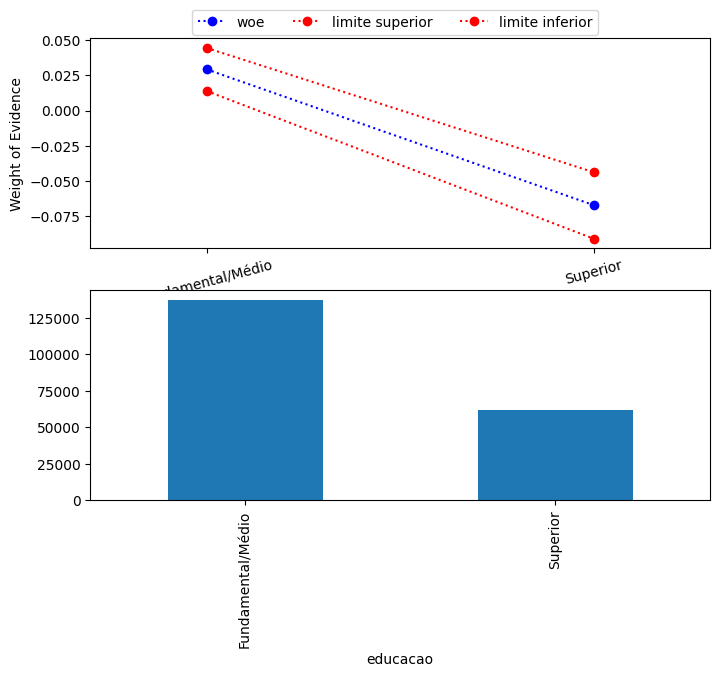

In [119]:
df_train2.educacao.replace({
    'Fundamental': 'Fundamental/Médio',
    'Médio': 'Fundamental/Médio',
    'Pós graduação': 'Superior',
    'Superior completo': 'Superior',
    'Superior incompleto': 'Superior'
    
}, inplace=True)
biv_discreta('educacao', df_train2);

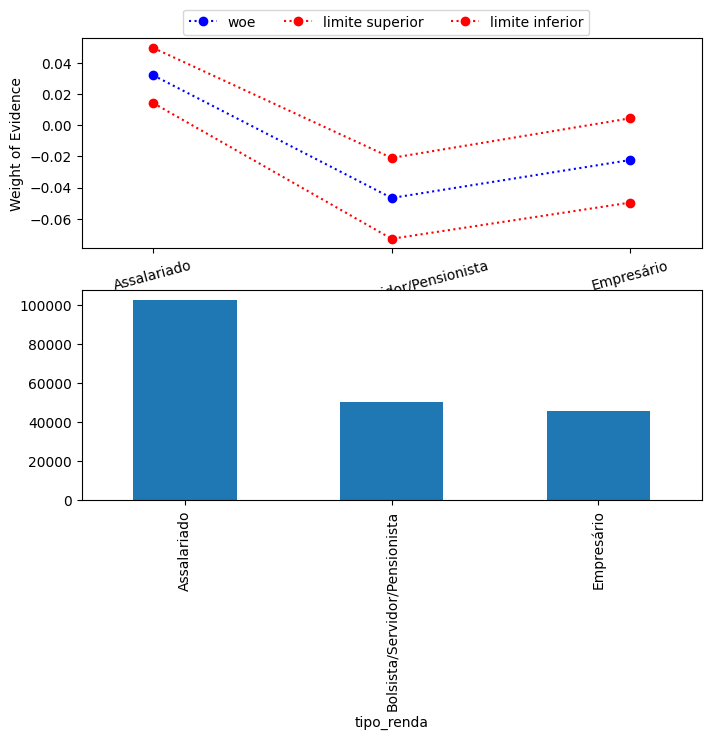

In [120]:
df_train2.tipo_renda.replace({
    'Bolsista': 'Bolsista/Servidor/Pensionista',
    'Servidor público': 'Bolsista/Servidor/Pensionista',
    'Pensionista': 'Bolsista/Servidor/Pensionista'
    
}, inplace=True)
biv_discreta('tipo_renda', df_train2);

- Proponha uma equação preditiva para 'mau'

In [121]:
' + '.join(list(df_train2.columns))

'data_ref + sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau + bom + qtd_filhos_cat + qt_pessoas_residencia_cat'

In [122]:
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + 
    tipo_renda + educacao + 
    tempo_emprego + renda
'''

rl = smf.glm(formula, data=df_train2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               198945
Model:                                     GLM   Df Residuals:                   198936
Model Family:                         Binomial   Df Model:                            8
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -72023.
Date:                         Fri, 28 Jul 2023   Deviance:                   1.4405e+05
Time:                                 18:32:37   Pearson chi2:                 4.51e+15
No. Iterations:                             10   Pseudo R-squ. (CS):            0.06495
Covariance Type:                     nonrobust                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.8905      0.018     49.673      0.000       0.855       0.926
sexo[T.M]                                       0.0856      0.016      5.417      0.000       0.055       0.117
posse_de_veiculo[T.S]                          -0.0334      0.015     -2.222      0.026      -0.063      -0.004
posse_de_imovel[T.S]                            0.0706      0.014      4.980      0.000       0.043       0.098
tipo_renda[T.Bolsista/Servidor/Pensionista]     0.1245      0.018      6.872      0.000       0.089       0.160
tipo_renda[T.Empresário]                        0.0342      0.017      1.996      0.046       0.001       0.068
educacao[T.Superior]                            0.0427      0.015      2.846      0.004       0.013       0.072
tempo_emprego                                   0.0140      0.002      7.204      0.000       0.010       0.018
renda                                        7.225e-05   1.05e-06     68.905      0.000    7.02e-05    7.43e-05
===============================================================================================================
"""

- Caso hajam categorias não significantes, justifique

<div style="background: #EEEEF4; padding: 15px 20px; border-radius: 5px; margin-top: 20px">
    <p style="font-size: 11px; color: #666; font-weight: bold">Resposta</p>
    <p>Quantidade de pessoas na residência e tipo de residência se mostraram estatisticamente não significantes e por isso foram removidas do modelo final</p>
</div>

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [127]:
y_train_pred = rl.predict(df_train2)
y_train_pred_labels = (y_train_pred >= 0.5).astype(int)

accuracy = accuracy_score(df_train2['mau'], y_train_pred_labels)
fpr, tpr, thresholds = roc_curve(df_train2['mau'], y_train_pred)
ks_statistic = max(tpr - fpr)
gini = 2 * auc(fpr, tpr) - 1

print("Base de Treino")
print("KS:", ks_statistic)
print("Gini:", gini)
print("Acurácia:", accuracy)

Base de Treino
KS: 0.0
Gini: -0.46308692746819957
Acurácia: 0.13490160597149967


In [130]:
df_oot2 = df_oot.copy()
df_oot2['tempo_emprego'] = df_oot2['tempo_emprego'].fillna(0)
df_oot2.educacao.replace({
    'Fundamental': 'Fundamental/Médio',
    'Médio': 'Fundamental/Médio',
    'Pós graduação': 'Superior',
    'Superior completo': 'Superior',
    'Superior incompleto': 'Superior'
    
}, inplace=True)
df_oot2.tipo_renda.replace({
    'Bolsista': 'Bolsista/Servidor/Pensionista',
    'Servidor público': 'Bolsista/Servidor/Pensionista',
    'Pensionista': 'Bolsista/Servidor/Pensionista'
    
}, inplace=True)


y_oot_pred = rl.predict(df_oot2)
y_oot_pred_labels = (y_oot_pred >= 0.5).astype(int)

accuracy = accuracy_score(df_oot2['mau'], y_oot_pred_labels)
fpr, tpr, thresholds = roc_curve(df_oot2['mau'], y_oot_pred)
ks_statistic = max(tpr - fpr)
gini = 2 * auc(fpr, tpr) - 1

print("Base OOT")
print("KS:", ks_statistic)
print("Gini:", gini)
print("Acurácia:", accuracy)

Base OOT
KS: 0.0
Gini: -0.4593735844164887
Acurácia: 0.13428
